# Testing the ingestion of calibration-day data

My initial implementation of run_create_ingested et al had the problem that calibration days failed. This is partially due to one of the calibration files having $1000<1200$ height bins, so inserting it into the xarray Dataset failed.

However, simply omitting the files seems to have problems with the Pandas indexing when ingesteing the data.

My aim is to fix this problem...

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [8]:
# importing local files for use...
from src import load_mpl_inline
from src import load_afterpulse

from src import raw_to_ingested
from src import calibrate_ingested

In [9]:
# setup path to load files from
dir_data = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/raw'
dir_output = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/leeds_ingested'

## Test date: `2019-07-11`

I will effectively go through the steps of `create_ingested.create_ingested` to see at which point the ingestion fails.

In [ ]:
def create_ingested(date,dir_target,dir_mpl, overwrite=False, afterpulse=None, overlap=None, sources={}):
    '''For a given date, create an ingested file and save it to the target directory.
    
    INPUTS:
        date : datetime.date
            The date for which data should be taken from.
            
        dir_target : string
            The directory into which the file should be saved.

        dir_mpl : string
            The directory from which the .mpl.gz files will be extracted.
            
        overwrite : boolean
            If true, pre-existing ingested files will be overwritten.

        afterpulse : xr.Dataset
            xarray dataset containing the information from the afterpulse file generated by load_afterpusle

        fname_overlap : xr.Dataset | 2xk np.ndarray
            Data for the overlap function that can be utilised in calibrate_ingested.
    '''
    # check to see if the ingested file already exists, and if it can be overwritten.
    save_fname = f'smtmplpolX1.a1.{date.year:04}{date.month:02}{date.day:02}.000000.cdf'
    if not overwrite:
        if os.path.isfile(os.path.join(dir_target,save_fname)):
            print(f'{save_fname} already exists.')
            return

    # create the filename format from the date
    fname_glob = f'{date.year:04}{date.month:02}{date.day:02}*.mpl.gz'
    print(fname_glob)
    ds = load_mpl_inline.mf_load_mpl_inline(fname_glob, dir_mpl)

    # apply the raw_to_ingested algorithm on the already-loaded ds
    ds = raw_to_ingested.raw_to_ingested(None, None, data_loaded=ds)

    # add calibrated variables to the ingested format
    ds = calibrate_ingested.calibrate_ingested(ds, afterpulse=afterpulse, overlap=overlap, sources=sources)

    # now save the dataset as a netcdf file
    ds.to_netcdf(os.path.join(dir_target, save_fname))
    return

In [12]:
# get the list of files...
date = datetime.date(2019,7,11)
save_fname = f'smtmplpolX1.a1.{date.year:04}{date.month:02}{date.day:02}.000000.cdf'

fname_glob = f'{date.year:04}{date.month:02}{date.day:02}*.mpl.gz'
print(fname_glob)
ds = load_mpl_inline.mf_load_mpl_inline(fname_glob, dir_data)

20190711*.mpl.gz
Loading: |0000|0100|0200|0300|0400|0500|0600|0700|0800|0900|1000|1100|1200|1226|1242|1255|1300|1400|1500|1600|1700|1800|1900|2000|2100|2200|2300|


ValueError: cannot reindex or align along dimension 'range' because of conflicting dimension sizes: {999, 1999}

Using `load_mpl_inline.mf_load_mpl_inline` has resulted in the `ds.combine_nested` function failing, as one of the calibration files has a different number f range bins.

```python
ValueError: cannot reindex or align along dimension 'range' because of conflicting dimension sizes: {999, 1999}
```

What if we say sod it and skip the files that don't begin on the hour...

In [15]:
fname_glob = f'{date.year:04}{date.month:02}{date.day:02}*00.mpl.gz' # note the additional 00
print(fname_glob)
ds = load_mpl_inline.mf_load_mpl_inline(fname_glob, dir_data)
ds

20190711*00.mpl.gz
Loading: |0000|0100|0200|0300|0400|0500|0600|0700|0800|0900|1000|1100|1200|1300|1400|1500|1600|1700|1800|1900|2000|2100|2200|2300|


<xarray.Dataset>
Dimensions:                      (profile: 16826, range: 1999)
Dimensions without coordinates: profile, range
Data variables: (12/52)
    unit                         (profile) float32 108.0 108.0 ... 108.0 108.0
    version                      (profile) float32 413.0 413.0 ... 413.0 413.0
    shots_sum                    (profile) float64 1.25e+04 ... 1.25e+04
    trigger_frequency            (profile) float64 2.5e+03 2.5e+03 ... 2.5e+03
    energy_monitor               (profile) float64 5.302e+03 ... 5.274e+03
    temp_0                       (profile) float64 1.849e+03 ... 1.777e+03
    ...                           ...
    channel_2                    (profile, range) float32 0.1152 ... 0.1008
    time_utc                     (profile) object '2019-07-11T00:00:00' ... '...
    time                         (profile) datetime64[ns] 2019-07-11 ... 2019...
    c                            (profile) float64 2.998e+08 ... 2.998e+08
    nrb_copol                    (profile, range) float64 2.411e-07 ... 0.7179
    nrb_crosspol                 (profile, range) float64 -1.249e-09 ... -0.3525
Attributes:
    created:   2023-03-14T:17:11:59Z
    software:  mpl2nc (https://github.com/peterkuma/mpl2nc)
    version:   1.3.5

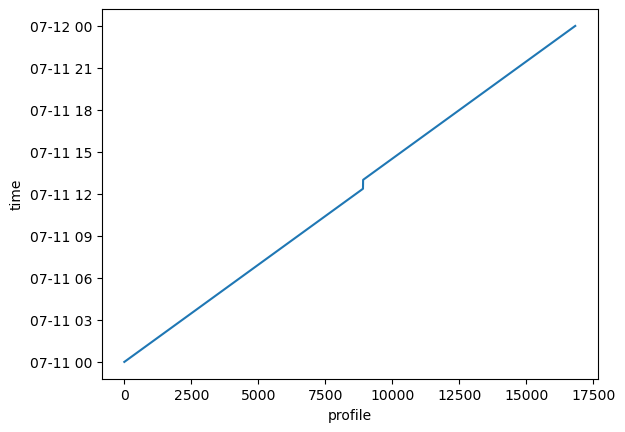

In [18]:
ds.time.plot()

In [19]:
# apply the raw_to_ingested algorithm on the already-loaded ds
ds = raw_to_ingested.raw_to_ingested(None, None, data_loaded=ds)

In [20]:
ds

<xarray.Dataset>
Dimensions:          (time: 16826, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-07-11 ... 2019-07-11T23:59:55
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/19)
    base_time        datetime64[ns] 2019-07-11
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:55
    hour             (time) float32 0.0 0.001389 0.002778 ... 24.0 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.302 5.301 5.301 ... 5.276 5.275 5.274
    ...               ...
    initial_cbh      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    backscatter_1    (time, height) float32 0.0928 0.096 ... 0.0864 0.0976
    backscatter_2    (time, height) float32 0.1152 0.1168 0.104 ... 0.088 0.1136
    lat              float32 72.6
    lon              float32 -38.42
    alt              float32 3.2e+03
Attributes:
    Date_created:              2023-03-14T17:15:50 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

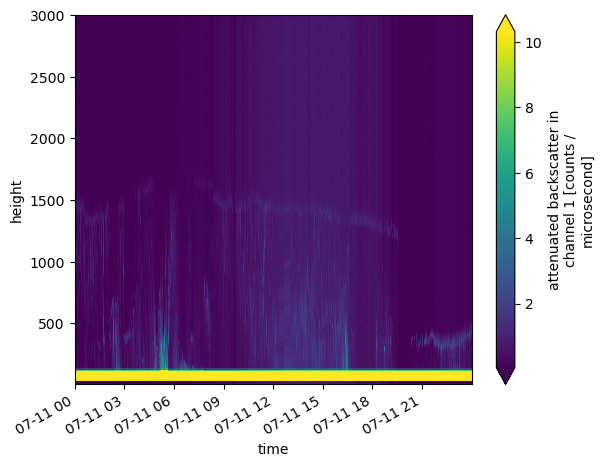

In [23]:
ds.backscatter_1.sel(height=slice(0,3000)).plot(x='time',y='height',robust=True)

In [26]:
# add calibrated variables to the ingested format
ds = calibrate_ingested.calibrate_ingested(ds, afterpulse=None, overlap=None, sources=None)
ds

<xarray.Dataset>
Dimensions:          (time: 16826, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-07-11 ... 2019-07-11T23:59:55
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/27)
    base_time        datetime64[ns] 2019-07-11
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:55
    hour             (time) float32 0.0 0.001389 0.002778 ... 24.0 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.302 5.301 5.301 ... 5.276 5.275 5.274
    ...               ...
    dz               float64 14.99
    E_photon         float64 3.734e-19
    NRB_2            (time, height) float64 nan nan nan nan ... nan nan nan nan
    depol_mpl        (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    depol_linear     (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NRB_total        (time, height) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Date_created:              2023-03-14T17:15:50 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

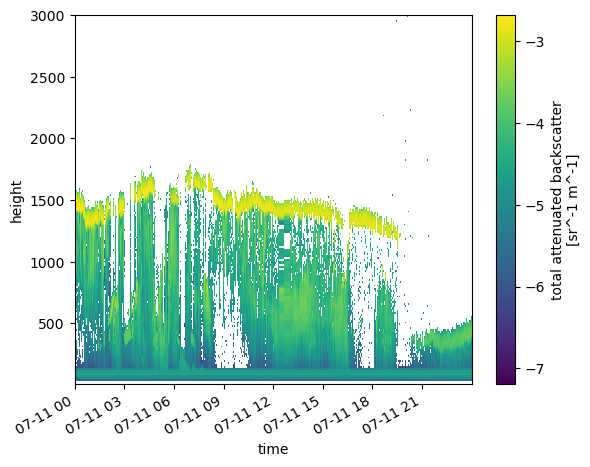

In [29]:
np.log10(ds.NRB_total.sel(height=slice(0,3000))).plot(x='time',y='height')

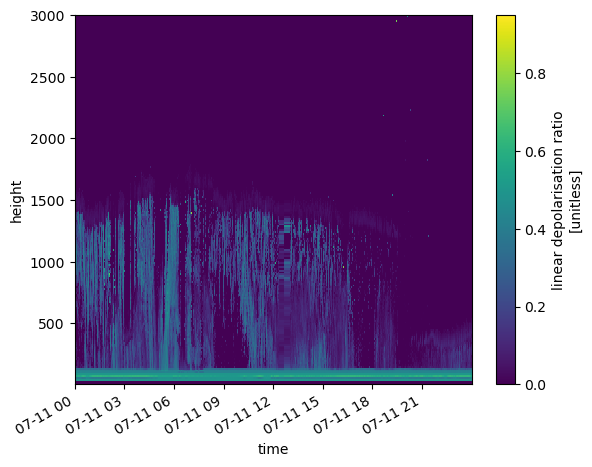

In [35]:
(ds.depol_linear.sel(height=slice(0,3000))).plot(x='time',y='height')

## Findings

So far, the only problem seems to be with loading in the calibration data. If we put the additional `*00.mpl.gz` in the glob string, this should work.